In [14]:
# ## install required packages

# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# ## install finrl library
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [15]:
# !pip install optuna

In [16]:
# !pip install stable-baselines3[extra]


In [17]:
# !pip install -U stable-baselines3==2.3.0 sb3-contrib==2.3.0

In [18]:
# !unzip -q /content/models.zip -d /content/models/

In [19]:
# import shutil
# import finrl
# import os

# # 1. Get the installed path of FinRL
# finrl_base = os.path.dirname(finrl.__file__)
# custom_model_path = "/content/models.py"  # Change if different

# # 2. Path to target file inside site-packages
# target_model_path = os.path.join(finrl_base, "agents", "stablebaselines3", "models.py")

# # 3. Replace the installed models.py with your uploaded one
# shutil.copy(custom_model_path, target_model_path)

# print(f"✅ Replaced: {target_model_path}")

In [20]:
# !pip install pyfolio


In [21]:
import sys
sys.path.append(r"D:\FinRL-master\FinRL-master")
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

In [22]:

import seaborn as sns
import sys
sys.path.append(r"D:\FinRL-master\FinRL-master")

# Paths & Test Data
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from stable_baselines3 import PPO
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS

%matplotlib inline
from finrl.config import INDICATORS
import torch
from torch import nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from stable_baselines3 import PPO
try:
    from sb3_contrib import RecurrentPPO
except ImportError:
    RecurrentPPO = None

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

import os
import numpy as np
import pandas as pd

from trading_dispatch import (
    set_env_kwargs,
    trade_Baselineppo,
    trade_metappo,
    trade_rppo,
    trade_riskppo,
    trade_risk_rppo,
    trade_transformerppo,
    trade_moppo,
    trade_constrainppo,
)

plt.rcParams['figure.figsize'] = (12, 3.2)

def compute_financial_metrics(values, steps_per_year=252):
    v = np.asarray(values, dtype=float)
    assert v.ndim == 1 and len(v) > 1, "values must be 1D series"
    r = np.diff(v) / v[:-1]
    mean_r = np.mean(r)
    std_r  = np.std(r, ddof=1) if len(r) > 1 else 0.0

    n = len(v) - 1
    ann_return = (v[-1] / v[0])**(steps_per_year / max(n, 1)) - 1
    ann_vol    = (std_r * np.sqrt(steps_per_year)) if std_r > 0 else 0.0
    sharpe     = (mean_r / std_r * np.sqrt(steps_per_year)) if std_r > 0 else 0.0

    peak = np.maximum.accumulate(v)
    dd = (v - peak) / peak
    max_dd_pct = dd.min() * 100.0  # negative percentage

    calmar = (ann_return / abs(max_dd_pct/100.0)) if max_dd_pct < 0 else np.inf

    return {
        "Annual Return": round(ann_return * 100.0, 2),
        "Annual Volatility": round(ann_vol * 100.0, 2),
        "Sharpe Ratio": round(sharpe, 2),
        "Calmar Ratio": round(calmar, 2 if np.isfinite(calmar) else 0),
        "Max Drawdown": f"{round(max_dd_pct, 1)}%"
    }

def initial_banner():
    print("Initial Account Value: $1,000,000.00")


In [23]:


BASE_DIR = 'project_root'
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load processed data (ensure these exist and include 'date', 'tic', 'close', etc.)
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

# >>> REPLACE THESE WITH YOUR REAL FOLDERS <<<
ppo = "D:\\FinRL-master\\FinRL-master\\Evalution\\models\\PPO"
MetaPPO = "D:\\FinRL-master\\FinRL-master\\Evalution\\models\\MetaPPO"
RPPO = "D:\\FinRL-master\\FinRL-master\\Evalution\\models\\RPPO"
RiskPPO = "D:\\FinRL-master\\FinRL-master\\Evalution\\models\\Riskppo"
RiskRPPO = "D:\\FinRL-master\\FinRL-master\\Evalution\\models\\RPPO_Risk"
TransformerPPO = "D:\\FinRL-master\\FinRL-master\\Evalution\\models\\Transf_PPO"
MOPPO = "D:\\FinRL-master\\FinRL-master\\Evalution\\models\\MMO_PPO"
ConstrainPPO = "D:\\FinRL-master\\FinRL-master\\Evalution\\models\\Constrain_PPO"

MODEL_PATHS = {
    "ppo": ppo,
    "metappo": MetaPPO,
    "rppo": RPPO,
    "riskppo": RiskPPO,
    "risk_rppo": RiskRPPO,
    "transformerppo": TransformerPPO,
    "moppo": MOPPO,
    "constrainppo": ConstrainPPO,
}



def _setup_env_kwargs(trade_df: pd.DataFrame, INDICATORS: list[str]) -> None:
    stock_dimension = int(trade_df["tic"].nunique())
    state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 1_000_000,
        "num_stock_shares": [0] * stock_dimension,
        "buy_cost_pct": [0.001] * stock_dimension,
        "sell_cost_pct": [0.001] * stock_dimension,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
    }
    set_env_kwargs(env_kwargs)  # inform trading_dispatch

TRADE_DISPATCH = {
    "ppo":            trade_Baselineppo,
    "metappo":        trade_metappo,
    "rppo":           trade_rppo,
    "riskppo":        trade_riskppo,
    "risk_rppo":      trade_risk_rppo,
    "transformerppo": trade_transformerppo,
    "moppo":          trade_moppo,
    "constrainppo":   trade_constrainppo,
}

def evaluate_algorithm(algo_name: str, trade_df: pd.DataFrame, INDICATORS: list[str], loop_count: int = 5) -> list[pd.Series]:
    """
    Returns: list of pd.Series (one per run), each: index=trade dates, name='account_value'
    """
    key = algo_name.strip().lower()
    if key not in TRADE_DISPATCH:
        raise ValueError(f"Unknown algorithm '{algo_name}'. Options: {list(TRADE_DISPATCH.keys())}")
    if key not in MODEL_PATHS:
        raise ValueError(f"No model path configured for '{algo_name}'. Update MODEL_PATHS.")

    _setup_env_kwargs(trade_df, INDICATORS)

    trade_fn = TRADE_DISPATCH[key]
    model_path_base = MODEL_PATHS[key]

    # trading_dispatch returns list of equity curves (list[list[float]])
    curves = trade_fn(model_path_base=model_path_base, trade_df=trade_df, loop_count=loop_count)

    # convert to Series with date index (safer alignment)
    trade_dates = pd.to_datetime(trade_df["date"].drop_duplicates().sort_values().values)
    series_list = []
    for vals in curves:
        n = min(len(vals), len(trade_dates))
        s = pd.Series(vals[:n], index=trade_dates[:n], name="account_value", dtype="float64")
        series_list.append(s)
    return series_list


In [24]:
RiskRPPO

'D:\\FinRL-master\\FinRL-master\\Evalution\\models\\RPPO_Risk'

In [25]:
trade.head(5)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2023-10-02,AAPL,172.064636,172.609304,169.271983,169.559178,52164500.0,0.0,-2.558756,183.367359,165.648056,45.243153,-87.977273,26.128938,176.366171,180.804583,17.610001,34.480455
0,2023-10-02,AMGN,252.198303,254.262779,250.370580,253.524112,1912300.0,0.0,3.867164,261.151693,237.536326,59.425455,72.228977,31.542915,247.539638,237.412814,17.610001,34.480455
0,2023-10-02,AXP,145.907867,146.317829,144.531574,144.873201,2657600.0,0.0,-3.052555,160.817412,143.761830,37.445545,-174.732820,36.526668,153.348367,158.819426,17.610001,34.480455
0,2023-10-02,BA,187.830002,192.440002,186.929993,191.470001,5244700.0,0.0,-8.257769,223.250012,185.200986,32.814602,-138.625438,66.417390,211.389666,218.712000,17.610001,34.480455
0,2023-10-02,CAT,262.851044,267.774902,261.419340,263.741028,1778200.0,0.0,-0.878849,277.101092,259.928766,51.346802,-69.197028,1.038567,268.083490,264.021855,17.610001,34.480455


In [ ]:
# Which algorithms to evaluate (order controls legend)
ENABLED_ALGOS = [
    "ppo",
    "metappo",
    "rppo",
    "riskppo",
    "risk_rppo",
    "transformerppo",
    "moppo",
    "constrainppo",
]

series_for_plot = {}   # algo -> pd.Series (mean account value by date)
runs_map = {}          # NEW: algo -> List[pd.Series] (aligned per-run curves)

os.makedirs(os.path.join(RESULTS_DIR, "ppo_eval"), exist_ok=True)  # also fix path (see item 4)

for algo in ENABLED_ALGOS:
    runs = evaluate_algorithm(algo, trade_df=trade, INDICATORS=INDICATORS, loop_count=5)
    if not runs:
        print(f"[Warning] No successful runs for {algo}")
        continue

    # Align by common dates across runs
    common_idx = runs[0].index
    for s in runs[1:]:
        common_idx = common_idx.intersection(s.index)
    aligned = [s.reindex(common_idx).astype(float) for s in runs]

    mean_series = pd.concat(aligned, axis=1).mean(axis=1)  # average across seeds
    series_for_plot[algo] = mean_series
    runs_map[algo] = aligned   # <-- this populates runs_map


In [ ]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

In [ ]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [ ]:
train.tail(5)

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
3458,2023-09-29,UNH,489.152252,494.672547,488.773870,494.643443,3006200.0,4.0,4.758837,499.945974,450.959705,55.148653,128.373582,19.202285,475.052337,477.039840,17.52,57.508153
3458,2023-09-29,V,226.621841,229.597360,226.267144,229.410156,6045200.0,4.0,-3.060780,250.759367,223.639085,41.887448,-154.263226,36.909317,237.730122,236.732695,17.52,57.508153
3458,2023-09-29,VZ,28.312365,28.609378,28.277421,28.495813,19787600.0,4.0,-0.276669,30.421853,28.184129,41.243781,-137.570590,33.867271,29.353075,29.363412,17.52,57.508153
3458,2023-09-29,WBA,20.083012,20.254585,18.854913,18.963276,25663400.0,4.0,-1.050146,20.962602,18.592988,36.119157,-53.011703,26.754766,20.958936,23.656806,17.52,57.508153
3458,2023-09-29,WMT,52.092018,53.134313,51.850984,53.101742,18842400.0,4.0,0.139502,54.027441,52.110898,50.578503,-24.940971,17.468320,52.619028,51.954637,17.52,57.508153


In [ ]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[172.065, 252.198, 145.908, ...,  27.745,  20.246,  52.147],
       [170.728, 247.179, 141.584, ...,  27.937,  20.363,  51.818],
       [171.976, 251.374, 143.126, ...,  27.552,  20.128,  52.441],
       ...,
       [199.983, 279.45 , 293.02 , ...,  42.808,  11.21 ,  97.353],
       [200.193, 278.4  , 292.621, ...,  42.444,  11.19 ,  97.013],
       [199.723, 283.54 , 294.636, ...,  42.641,  11.24 ,  96.874]])

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.111 0.065 0.06  0.069 0.072 0.095 0.047 0.052 0.044 0.041 0.089 0.065
 0.027 0.046 0.043 0.061 0.038 0.06  0.025 0.053 0.089 0.071 0.043 0.054
 0.099 0.084 0.027 0.012 0.048]
Variance-Covariance matrix of returns
 [[3.196 0.949 1.409 1.618 1.351 1.859 1.415 1.091 1.236 1.404 1.247 1.242
  1.022 1.667 0.667 1.294 0.693 0.835 1.068 0.693 1.739 1.329 0.696 0.837
  1.124 1.414 0.543 0.983 0.655]
 [0.949 2.305 1.006 0.93  0.992 1.097 0.964 0.865 0.875 1.039 0.921 0.973
  0.808 1.104 0.865 1.052 0.625 0.641 0.883 1.002 1.004 0.828 0.699 0.811
  1.076 0.98  0.609 0.998 0.61 ]
 [1.409 1.006 3.426 2.516 1.926 1.679 1.435 1.805 1.806 2.225 1.403 1.801
  1.314 1.58  0.805 2.337 0.971 1.053 1.399 0.877 1.435 1.546 0.723 1.464
  1.341 1.858 0.736 1.251 0.582]
 [1.618 0.93  2.516 5.157 2.126 1.819 1.487 2.018 1.951 2.194 1.527 2.079
  1.456 1.822 0.817 2.24  1.062 1.172 1.464 0.843 1.501 1.72  0.727 1.527
  1.376 1.734 0.721 1.417 0.597]
 [1.351 0.992 1.92

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([248190.,  14900.,      0.,      0.,      0.,   5590.,      0.,
            0.,      0.,      0., 190580.,      0.,      0.,      0.,
            0.,      0.,      0., 111530.,      0.,  24280.,  13000.,
            0.,      0.,      0., 277910.,  42680.,      0.,      0.,
        71340.])

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1463.822,   58.542,    0.   ,    0.   ,    0.   ,   27.808,
          0.   ,    0.   ,    0.   ,    0.   ,  658.71 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  441.225,
          0.   ,  248.607,   41.724,    0.   ,    0.   ,    0.   ,
        568.146,  188.331,    0.   ,    0.   , 1369.5  ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2023-10-02,1.005879e+06
2023-10-03,9.929164e+05
2023-10-04,9.981442e+05
2023-10-05,1.000998e+06
2023-10-06,1.008246e+06
...,...
2025-05-22,1.099661e+06
2025-05-23,1.087180e+06
2025-05-27,1.103069e+06
2025-05-28,1.101707e+06


In [ ]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-10-01'
TRADE_START_DATE = '2023-10-01'
TRADE_END_DATE = '2025-06-01'


In [ ]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^DJI']).fetch_data()
# df_dji

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (417, 8)


In [ ]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')
dji

,close
date,
2023-10-02,1.000000e+06
2023-10-03,9.871095e+05
2023-10-04,9.909132e+05
2023-10-05,9.906147e+05
2023-10-06,9.992291e+05
...,...
2025-05-23,1.244358e+06
2025-05-27,1.266509e+06
2025-05-28,1.259183e+06


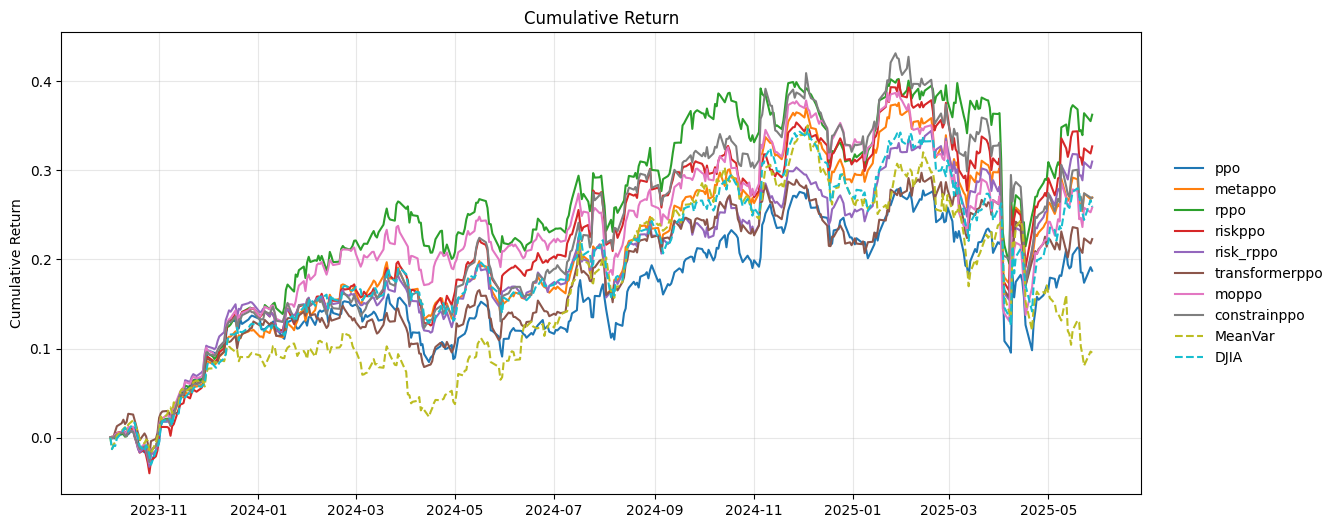

In [ ]:
# --- 1) Add financial baselines to series_for_plot (if present) ---
baseline_series = {}
trade_dates_full = pd.to_datetime(trade["date"].drop_duplicates().values)

# Mean-Var (MVO) – try common column names
if 'MVO_result' in globals():
    for col in ["Mean Var", "MeanVar", "MinVar"]:
        if col in MVO_result.columns:
            mv_vals = MVO_result[col].to_numpy(dtype="float64", copy=False)
            n = min(len(mv_vals), len(trade_dates_full))
            baseline_series["MeanVar"] = pd.Series(mv_vals[:n], index=trade_dates_full[:n], name="MeanVar")
            break  # stop at the first match

# DJIA baseline
if 'dji' in globals() and "close" in dji.columns:
    dj_vals = dji["close"].to_numpy(dtype="float64", copy=False)
    n = min(len(dj_vals), len(trade_dates_full))
    baseline_series["DJIA"] = pd.Series(dj_vals[:n], index=trade_dates_full[:n], name="DJIA")

# Inject into the same dict used for plotting
series_for_plot.update(baseline_series)

# --- 2) Recompute L with baselines included, build cumret_df, and plot ---
dates_all = pd.to_datetime(trade["date"].drop_duplicates().values)
L = min([len(dates_all)] + [len(v) for v in series_for_plot.values()])
dates = dates_all[:L]

cumret_df = pd.DataFrame({"date": dates})
for label, series in series_for_plot.items():
    v = np.asarray((series.iloc[:L] if hasattr(series, "iloc") else series[:L]), dtype=float)
    cumret_df[label] = (v / v[0]) - 1.0

# melt to long form for seaborn
plot_df = cumret_df.melt(id_vars="date", var_name="Series", value_name="Cumulative Return")

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(16, 6), constrained_layout=False)

# Build a complete dashes map so seaborn doesn't error about missing levels
series_levels = plot_df["Series"].astype(str).unique().tolist()
dashes_map = {s: "" for s in series_levels}  # default: solid
# make baselines dashed/dotted (handle either 'MeanVar' or 'Mean Var')
for mv_name in ("MeanVar", "Mean Var", "MinVar"):
    if mv_name in dashes_map:
        dashes_map[mv_name] = (4, 2)
if "DJIA" in dashes_map:
    dashes_map["DJIA"] = (2, 1)

sns.lineplot(
    data=plot_df,
    x="date", y="Cumulative Return",
    hue="Series",
    style="Series",
    style_order=series_levels,      # align styles with our mapping
    dashes=dashes_map,              # dynamic dashed mapping
    linewidth=2,
    ax=ax
)

ax.set_title("Cumulative Return")
ax.set_ylabel("Cumulative Return")
ax.set_xlabel("")
ax.grid(True, alpha=0.3)

# move legend outside (right side)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

# leave room on the right for the legend
plt.subplots_adjust(right=0.8)

os.makedirs(os.path.join(RESULTS_DIR, "ppo_eval"), exist_ok=True)
fig.savefig(os.path.join(RESULTS_DIR, "ppo_eval", "ppo_cumreturn.png"), dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
# Average financial metrics table (per algo, averaged across runs)
rows = []
for agent, run_series_list in runs_map.items():
    metric_bags = []
    for s in run_series_list:
        metrics = compute_financial_metrics(s.values)  # uses account value series
        metric_bags.append(metrics)

    if metric_bags:
        dfm = pd.DataFrame(metric_bags)
        dfm["_dd_num"] = dfm["Max Drawdown"].str.rstrip("%").astype(float)

        out = {
            "Agent": agent,
            "Annual Return": round(dfm["Annual Return"].mean(), 2),
            "Annual Volatility": round(dfm["Annual Volatility"].mean(), 2),
            "Sharpe Ratio": round(dfm["Sharpe Ratio"].mean(), 2),
            "Calmar Ratio": round(dfm["Calmar Ratio"].replace(np.inf, np.nan).mean(skipna=True), 2),
            "Max Drawdown": f"{round(dfm['_dd_num'].mean(), 1)}%"
        }
        rows.append(out)

baseline_labels = []
for name in ["MinVar", "MeanVar", "mean-var", "DJIA", "SP500", "S&P500", "Baseline"]:
    if name in series_for_plot:
        baseline_labels.append(name)

for label in baseline_labels:
    s = series_for_plot[label]
    # ensure numeric and drop any NaNs
    arr = (s.values if hasattr(s, "values") else np.asarray(s)).astype(float)
    arr = arr[~np.isnan(arr)]
    if len(arr) < 2:
        print(f"[skip] baseline {label}: series too short")
        continue

    m = compute_financial_metrics(arr)
    rows.append({
        "Agent": label,
        "Annual Return": m["Annual Return"],
        "Annual Volatility": m["Annual Volatility"],
        "Sharpe Ratio": m["Sharpe Ratio"],
        "Calmar Ratio": m["Calmar Ratio"],
        "Max Drawdown": m["Max Drawdown"],
    })

df_metrics = pd.DataFrame(
    rows,
    columns=["Agent", "Annual Return", "Annual Volatility", "Sharpe Ratio", "Calmar Ratio", "Max Drawdown"]
)
df_metrics.to_csv(os.path.join(RESULTS_DIR, 'ppo_metrics_comparison.csv'), index=False)
df_metrics


,Agent,Annual Return,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown
0,ppo,10.86,17.97,0.71,0.71,-19.8%
1,metappo,15.51,16.24,0.95,0.94,-17.2%
2,rppo,20.67,16.92,1.21,1.29,-17.7%
3,riskppo,18.37,17.50,1.03,1.10,-17.7%
4,risk_rppo,17.76,15.60,1.13,1.14,-15.8%
5,transformerppo,12.80,14.98,0.87,0.97,-14.9%
6,moppo,14.71,18.12,0.79,0.67,-21.8%
7,constrainppo,15.35,19.86,0.78,0.75,-21.2%
8,MeanVar,5.65,15.79,0.43,0.28,-20.0%
9,DJIA,15.21,14.92,1.02,0.93,-16.4%
